# Recognition Memory
## Computational Methods in Psychology and Neuroscience
### Psychology 4215/7215 --- Fall 2023
By: Per B. Sederberg, PhD



# Lesson Objectives

Upon completion of this lesson, students should have learned:

1. Some basic probability
2. Strength theories of memory
3. its relation to Signal Detection Theory
4. How to calculate sensitivity (d', or d-prime) and bias (c)
5. Plotting and statistics with d-prime and bias


# New library to install

You're going to need a new plotting library, so run this line at your Anaconda Prompt/Terminal:

`conda install -c conda-forge plotnine` 

In [1]:
# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
import plotnine as pn
import scipy.stats.distributions as dists     # probability distributions
from scipy import stats
from glob import glob
import os

from smile.log import log2dl

from ci_within import ci_within

## Custom SLOG loading function

In [2]:
# custom function to load slogs
def load_all_subj_logs(data_dir, log_file):
    # load in a list of all the subj
    subjs = [os.path.splitext(os.path.split(filepath)[1])[0].split('_')[-1]
             for filepath in glob(os.path.join(data_dir, log_file + '*.slog'))]
    subjs.sort()

    # loop over subj and their data
    all_dat = []
    for subj in subjs:
        # set the file
        log_path = os.path.join(data_dir, log_file+'_'+subj+'.slog')
        #print(log_path)

        # load the data
        try:
            all_dat.extend(log2dl(log_path, subj=subj))
        except:
            pass

    df = pd.DataFrame(all_dat)
    
    return df

## Load in all the data

In [3]:
# load the data from each task
data_dir = 'refresh_dat'
df_s = load_all_subj_logs(data_dir, 'log_refresh_study')
df_t = load_all_subj_logs(data_dir, 'log_refresh_test')
df_t.head()

,resp_map_target,resp_map_lure,block_num,trial_num,stim_on_time,stim_on_error,resp,resp_time_time,resp_time_error,rt,...,arousal_sd,dominance_mean,dominance_sd,word_frequency,valence,cond,pres_num,type,subj,log_num
0,J,F,0,0,141.686912,0.0,J,144.111953,0.000479,2.425040,...,2.71,3.9300000000000002,2.29,38,neg,repeat,1,target,s000,0
1,J,F,0,1,145.325594,0.0,F,146.409344,0.000517,1.083750,...,2.6299999999999999,5.7999999999999998,2.1600000000000001,13,pos,repeat,1,lure,s000,0
2,J,F,0,2,147.322170,0.0,F,148.306278,0.000450,0.984108,...,2.3399999999999999,3.98,1.8999999999999999,3,neg,refresh,1,lure,s000,0
3,J,F,0,3,149.190018,0.0,F,150.066530,0.002967,0.876512,...,2.5899999999999999,6.4000000000000004,2.29,37,pos,refresh,1,lure,s000,0
4,J,F,0,4,151.307007,0.0,F,152.004527,0.000440,0.697521,...,2.4900000000000002,4.6799999999999997,1.8500000000000001,37,neu,once,1,lure,s000,0


## Some data clean-up

In [4]:
# add in log_rt columns
df_t['log_rt'] = np.log(df_t['rt'])

# must make correct an int
df_t['correct'] = df_t['correct'].astype(int)

# add in a column for whether they made an 'old' response
df_t['old_resp'] = (df_t['resp_map_target'] == df_t['resp']).astype(int)


In [5]:
df_t.head()

,resp_map_target,resp_map_lure,block_num,trial_num,stim_on_time,stim_on_error,resp,resp_time_time,resp_time_error,rt,...,dominance_sd,word_frequency,valence,cond,pres_num,type,subj,log_num,log_rt,old_resp
0,J,F,0,0,141.686912,0.0,J,144.111953,0.000479,2.425040,...,2.29,38,neg,repeat,1,target,s000,0,0.885848,1
1,J,F,0,1,145.325594,0.0,F,146.409344,0.000517,1.083750,...,2.1600000000000001,13,pos,repeat,1,lure,s000,0,0.080428,0
2,J,F,0,2,147.322170,0.0,F,148.306278,0.000450,0.984108,...,1.8999999999999999,3,neg,refresh,1,lure,s000,0,-0.016020,0
3,J,F,0,3,149.190018,0.0,F,150.066530,0.002967,0.876512,...,2.29,37,pos,refresh,1,lure,s000,0,-0.131805,0
4,J,F,0,4,151.307007,0.0,F,152.004527,0.000440,0.697521,...,1.8500000000000001,37,neu,once,1,lure,s000,0,-0.360223,0


In [6]:
df_t.groupby(['subj', 'cond'])['correct'].mean()

subj  cond   
s000  once       0.763889
      refresh    0.777778
      repeat     0.791667
s001  once       0.736111
      refresh    0.750000
                   ...   
s022  refresh    0.875000
      repeat     0.944444
s023  once       0.847222
      refresh    0.805556
      repeat     0.888889
Name: correct, Length: 72, dtype: float64

# Image Recognition Figure

- Recognition memory performance is about more than simply whether you got a response correct
- There are two different ways we are probing memory: 
  - With old (target) items and with new (lure) items
- We can explore that by plotting the probability of making an `old` response, split out by novelty of the test item

In [7]:
# get the error corrected by condition and whether they said old
res = ci_within(df_t,  
                indexvar='subj',       # column that identifies a subject
                withinvars=['cond', 'type', 'valence'],     # list of columns for grouping within subject
                measvar='old_resp')        # dependent variable averaging over
res

mean       std       sem        ci  len
cond    type   valence                                             
once    lure   neg      0.076389  0.282178  0.016628  0.032727  288
               neu      0.065972  0.259087  0.015267  0.030049  288
               pos      0.079861  0.284216  0.016748  0.032964  288
        target neg      0.812500  0.390380  0.023003  0.045277  288
               neu      0.791667  0.396480  0.023363  0.045984  288
               pos      0.753472  0.420858  0.024799  0.048812  288
refresh lure   neg      0.076389  0.280112  0.016506  0.032488  288
               neu      0.065972  0.261123  0.015387  0.030285  288
               pos      0.104167  0.319177  0.018808  0.037018  288
        target neg      0.850694  0.349006  0.020565  0.040478  288
               neu      0.795139  0.393899  0.023211  0.045685  288
               pos      0.763889  0.427277  0.025178  0.049556  288
repeat  lure   neg      0.069444  0.268924  0.015846  0.031190  288
               neu      0.048611  0.236083  0.013911  0.027381  288
               pos      0.062500  0.251813  0.014838  0.029206  288
        target neg      0.888889  0.308021  0.018150  0.035725  288
               neu      0.847222  0.350700  0.020665  0.040675  288
               pos      0.819444  0.376973  0.022213  0.043722  288

In [8]:
# must unstack and reset index to plot properly
res.unstack().reset_index()

cond    type      mean                           std            \
valence                        neg       neu       pos       neg       neu   
0           once    lure  0.076389  0.065972  0.079861  0.282178  0.259087   
1           once  target  0.812500  0.791667  0.753472  0.390380  0.396480   
2        refresh    lure  0.076389  0.065972  0.104167  0.280112  0.261123   
3        refresh  target  0.850694  0.795139  0.763889  0.349006  0.393899   
4         repeat    lure  0.069444  0.048611  0.062500  0.268924  0.236083   
5         repeat  target  0.888889  0.847222  0.819444  0.308021  0.350700   

                        sem                            ci                      \
valence       pos       neg       neu       pos       neg       neu       pos   
0        0.284216  0.016628  0.015267  0.016748  0.032727  0.030049  0.032964   
1        0.420858  0.023003  0.023363  0.024799  0.045277  0.045984  0.048812   
2        0.319177  0.016506  0.015387  0.018808  0.032488  0.030285  0.037018   
3        0.427277  0.020565  0.023211  0.025178  0.040478  0.045685  0.049556   
4        0.251813  0.015846  0.013911  0.014838  0.031190  0.027381  0.029206   
5        0.376973  0.018150  0.020665  0.022213  0.035725  0.040675  0.043722   

         len            
valence  neg  neu  pos  
0        288  288  288  
1        288  288  288  
2        288  288  288  
3        288  288  288  
4        288  288  288  
5        288  288  288

Text(0, 0.5, 'Performance')

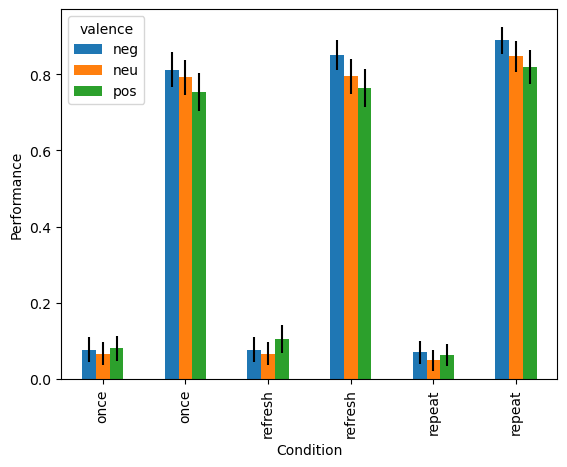

In [9]:
# plot the results
ax = res.unstack().reset_index().plot(x='cond', y='mean', yerr='ci', kind="bar")
#ax.get_legend().remove()
ax.set_xlabel('Condition')
ax.set_ylabel('Performance')

## Can we improve that plot?

- It looks like we've run up against the max level of complexity Pandas can easily handle.
- Let's explore the `plotnine` package, which provides a "Grammar of Graphics" (port of `ggplot` from R to Python)

In [10]:
# we won't need to unstack, but we will still need to reset the index
res = res.reset_index()
res

,cond,type,valence,mean,std,sem,ci,len
0,once,lure,neg,0.076389,0.282178,0.016628,0.032727,288
1,once,lure,neu,0.065972,0.259087,0.015267,0.030049,288
2,once,lure,pos,0.079861,0.284216,0.016748,0.032964,288
3,once,target,neg,0.812500,0.390380,0.023003,0.045277,288
4,once,target,neu,0.791667,0.396480,0.023363,0.045984,288
5,once,target,pos,0.753472,0.420858,0.024799,0.048812,288
6,refresh,lure,neg,0.076389,0.280112,0.016506,0.032488,288
7,refresh,lure,neu,0.065972,0.261123,0.015387,0.030285,288
8,refresh,lure,pos,0.104167,0.319177,0.018808,0.037018,288
9,refresh,target,neg,0.850694,0.349006,0.020565,0.040478,288


## Plotnine / ggplot

- In plotnine, you start with initializing a figure with the data you're going to plot, specifying the general `aesthetics` of what the plot will look like (i.e., what will go on each axis, what colors should they have, how to split out groups, etc...
- Then you add in `geoms` that specify how to map your data to specific visual properties of your figure
- You can also specify rules for how to split out a figure into sub plots
- Finally, you can customize the labels as needed

Let's build this plot, step by step!

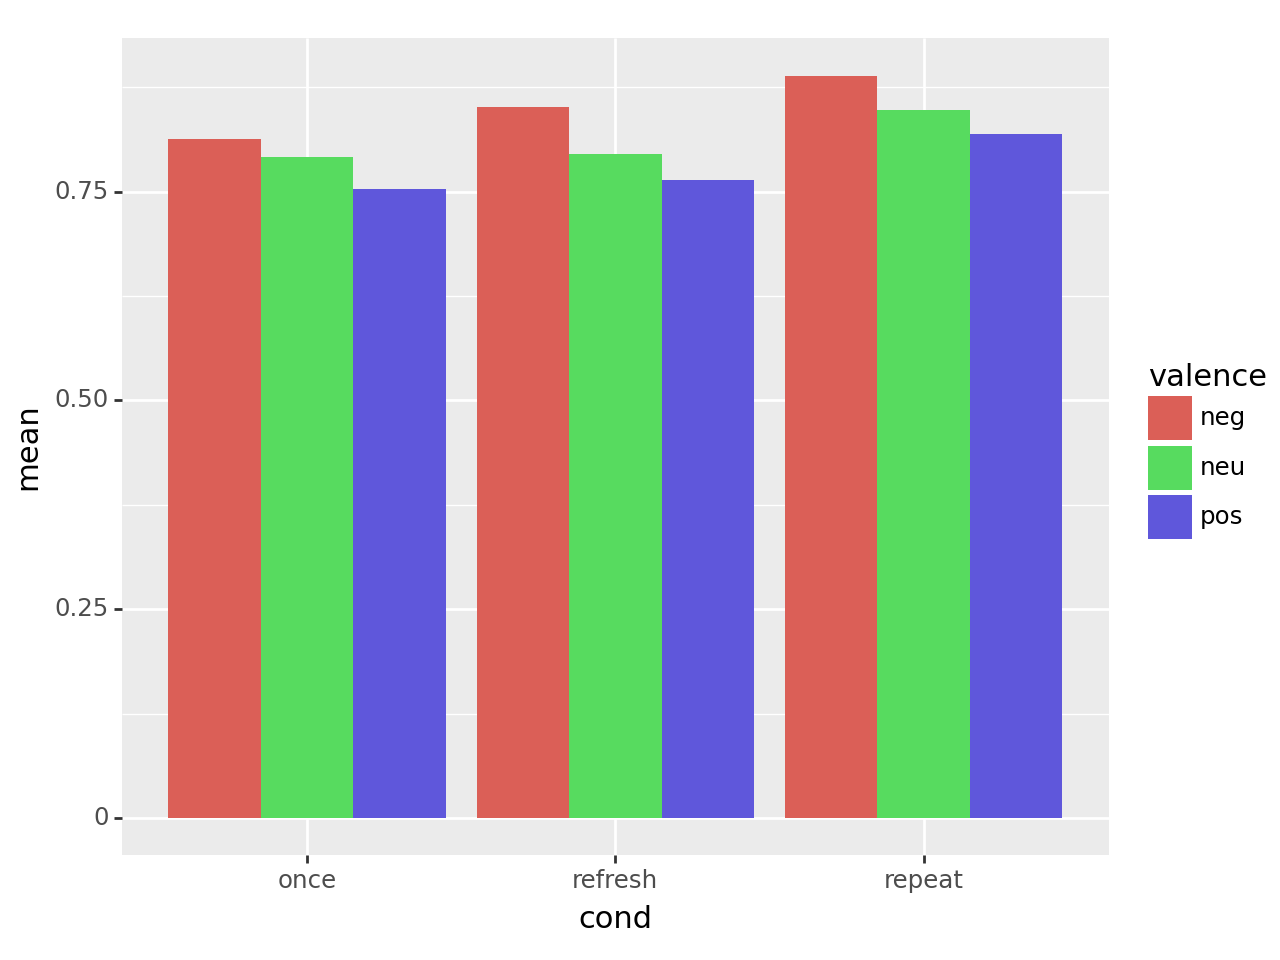

<Figure Size: (640 x 480)>

In [11]:
# start with a basic bar plot (specifying to dodge the position, so they are not stacked)
p = (pn.ggplot(res, pn.aes('cond', 'mean', fill='valence'))
 + pn.geom_bar(stat='identity', position=pn.position_dodge(.9))
)
p

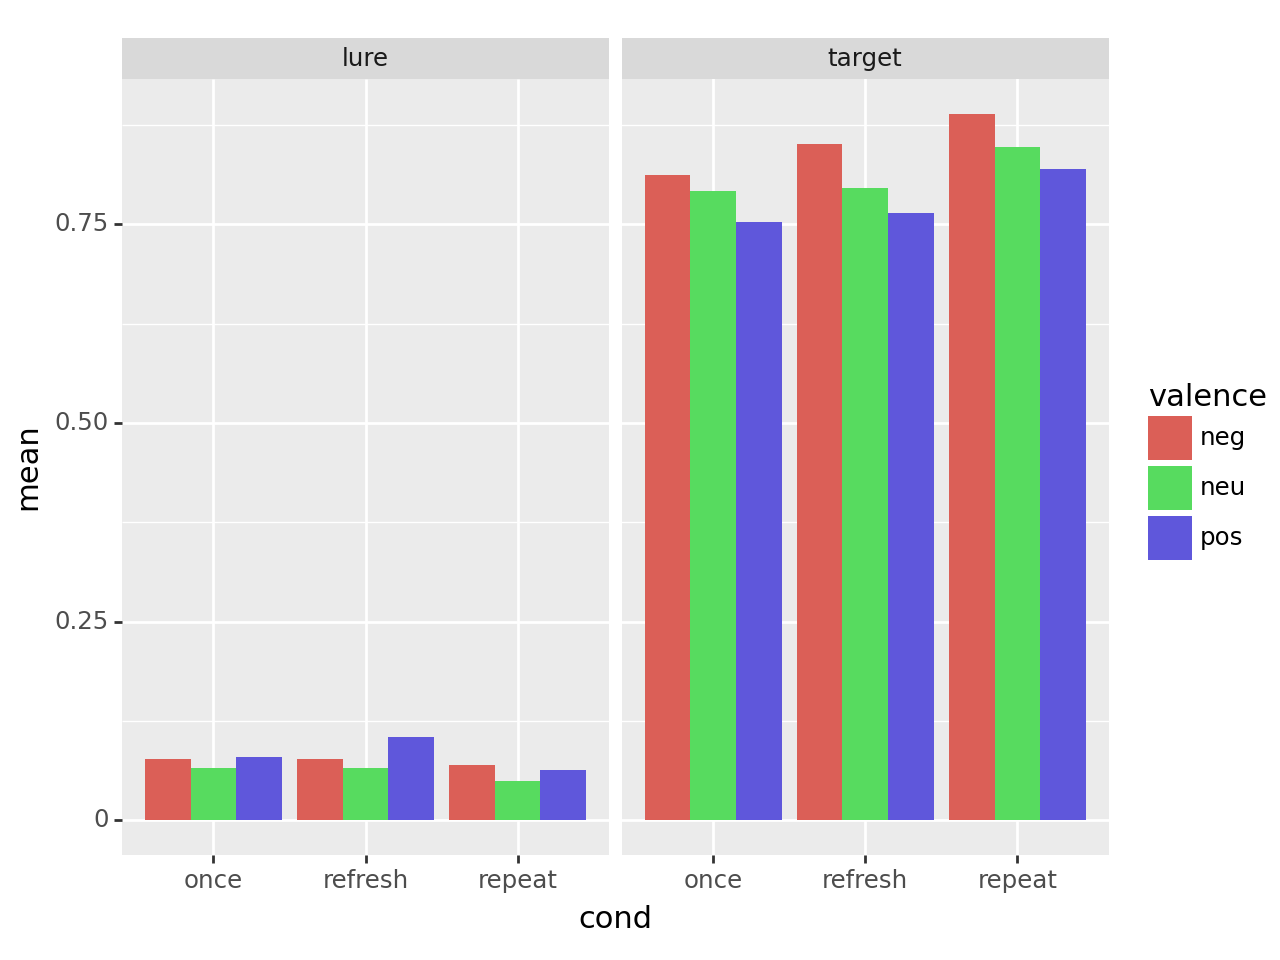

<Figure Size: (640 x 480)>

In [12]:
# add in separate plots for novelty because they were on top of each other
p += pn.facet_wrap('~type')
p

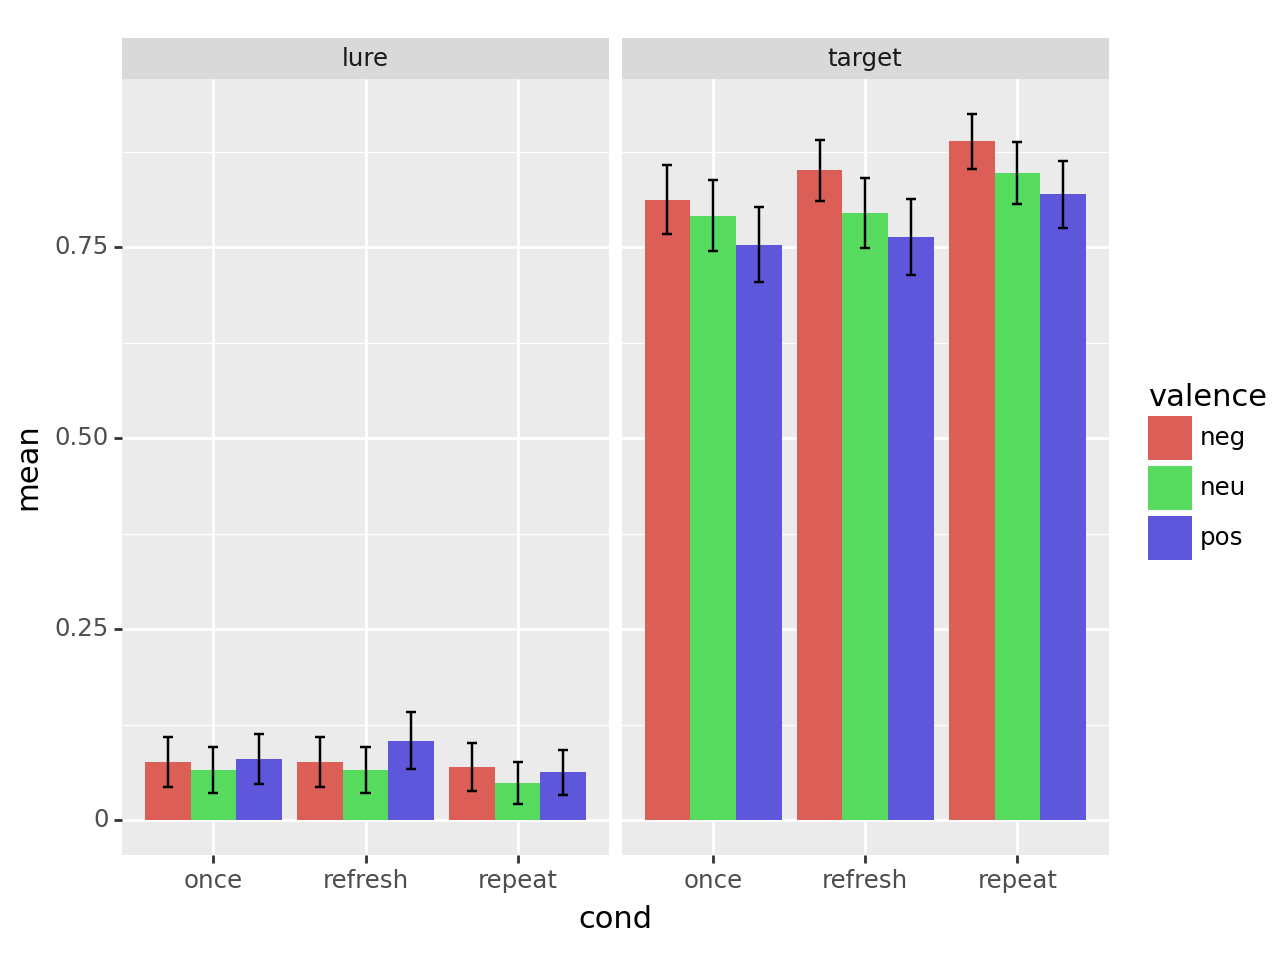

<Figure Size: (640 x 480)>

In [13]:
# and now the error bars
p += pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', 
                             width=0.2), 
                      position=pn.position_dodge(.9))   # needs to use the same dodge as the bars
p

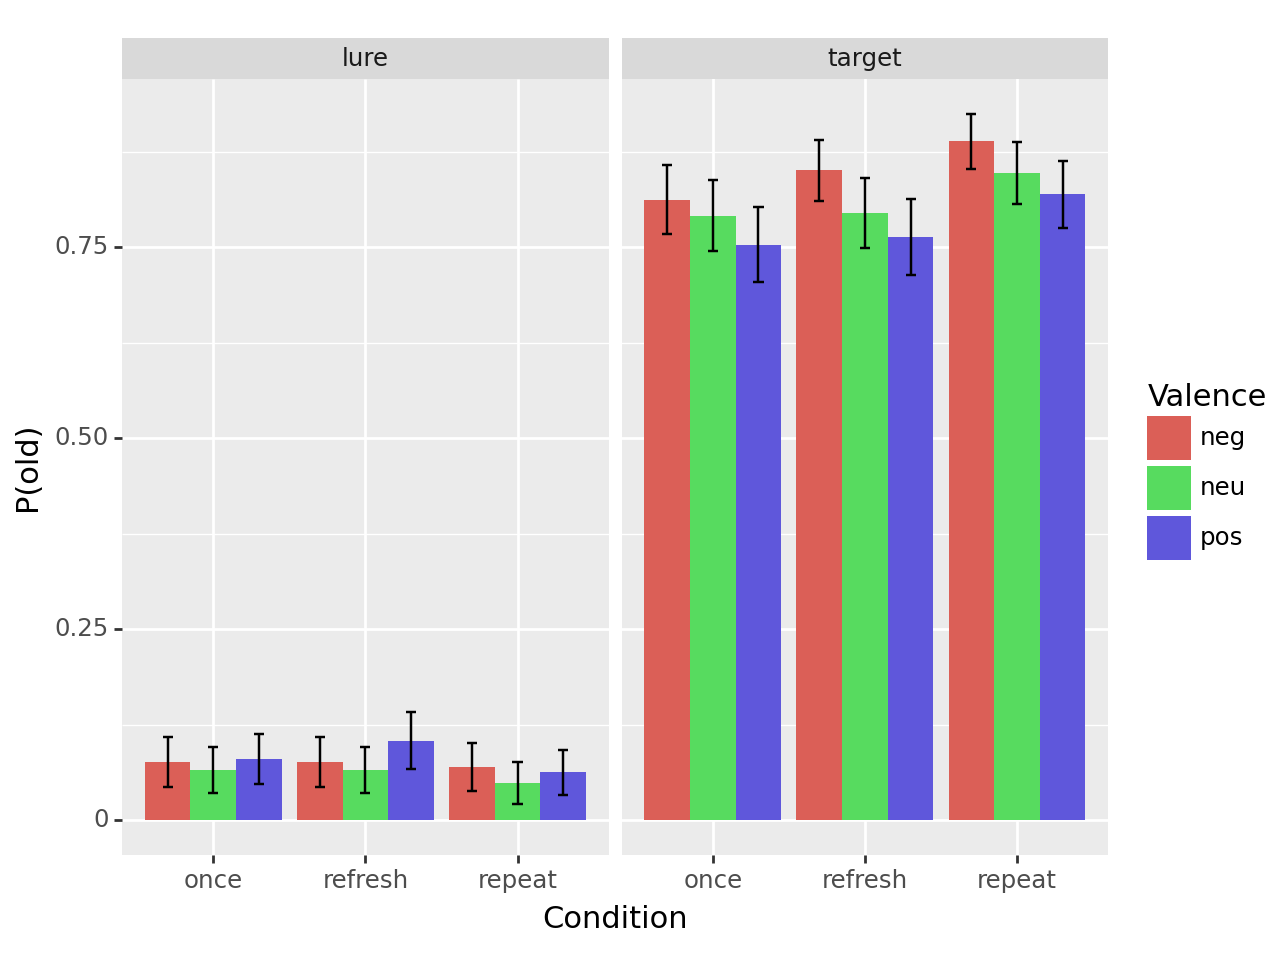

<Figure Size: (640 x 480)>

In [14]:
# finally fix up the labels
p += pn.labs(x="Condition", y = "P(old)", fill='Valence')
p

## What if we wanted points instead of bars?

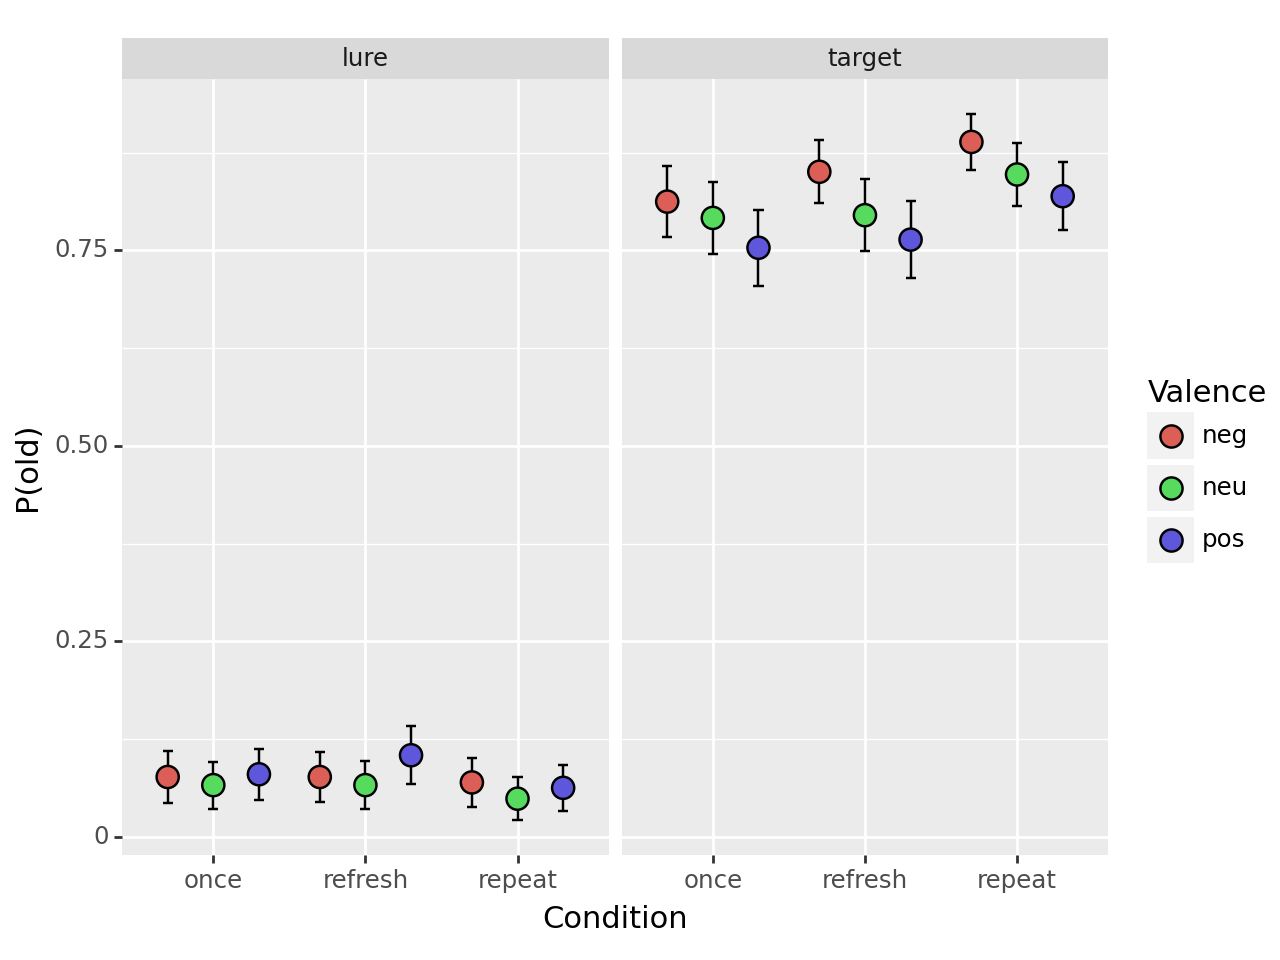

<Figure Size: (640 x 480)>

In [15]:
p = (pn.ggplot(res, pn.aes('cond', 'mean', fill='valence'))
     + pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', width=0.2), 
                        position=pn.position_dodge(.9))
     + pn.geom_point(position=pn.position_dodge(.9), size=4)
     + pn.facet_wrap('~type')
     + pn.labs(x="Condition", y = "P(old)", fill='Valence')
    )
p

# Probability Theory

At the core of probability theory are the mathematical functions determining the probability of the potential outcomes of an experiment. 

In statistics, these distributions represent the models that attempt to describe the observed data. The equations take in parameters that determine the shape of the probability distributions.

***Note: The area under a probability distribution must equal 1.0!***

## Uniform distribution

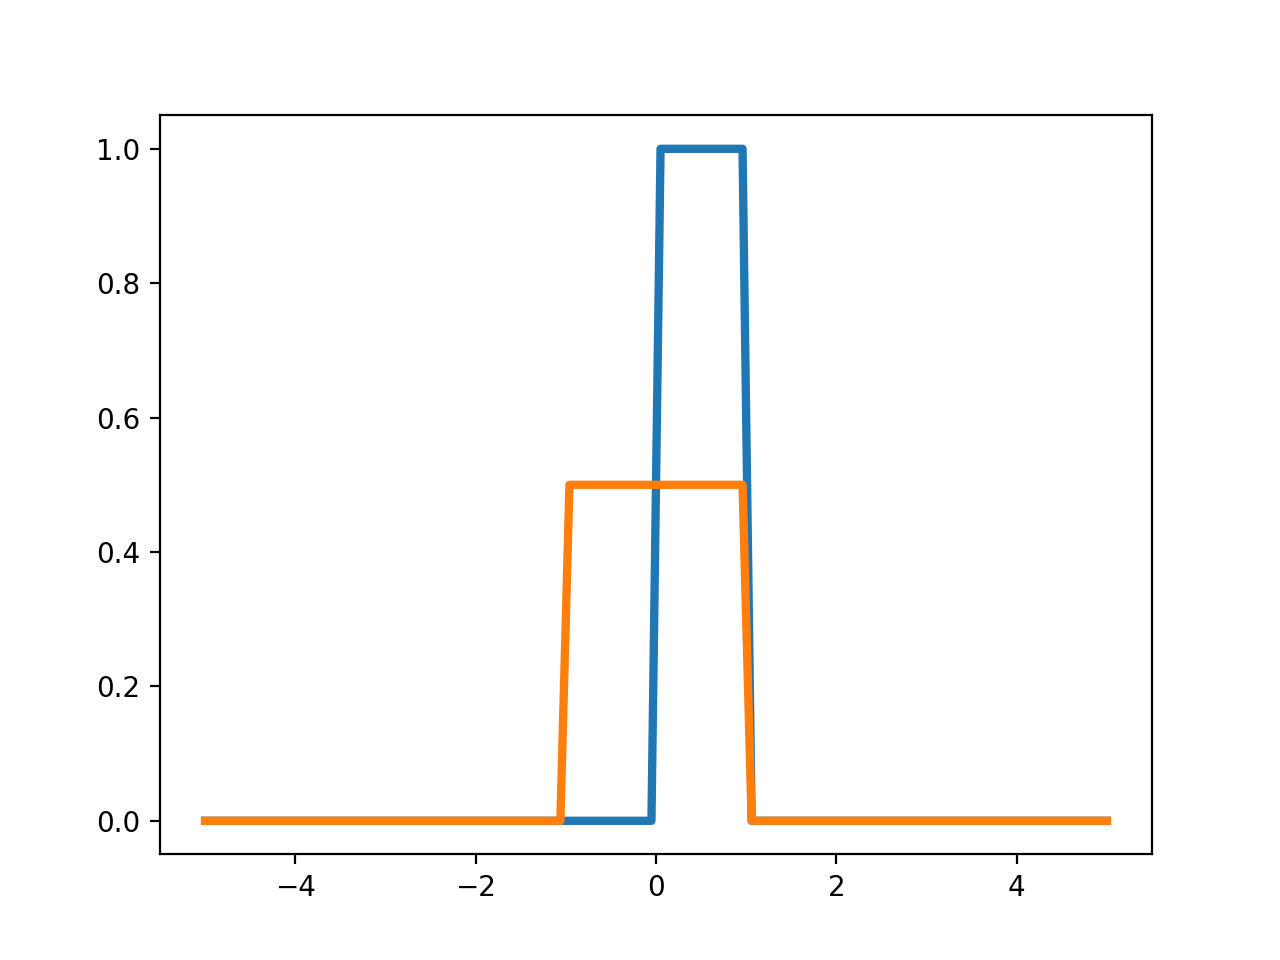

In [16]:
# x values to evaluate
x = np.linspace(-5, 5, 100)

# uniform distribution between 0 and 1
d = dists.uniform(loc=0.0, scale=1.0)
plt.plot(x, d.pdf(x), lw=3)

# uniform distribution between -1 and 1
d = dists.uniform(loc=-1, scale=2.0)
plt.plot(x, d.pdf(x), lw=3)

## The Normal / Gaussian distribution



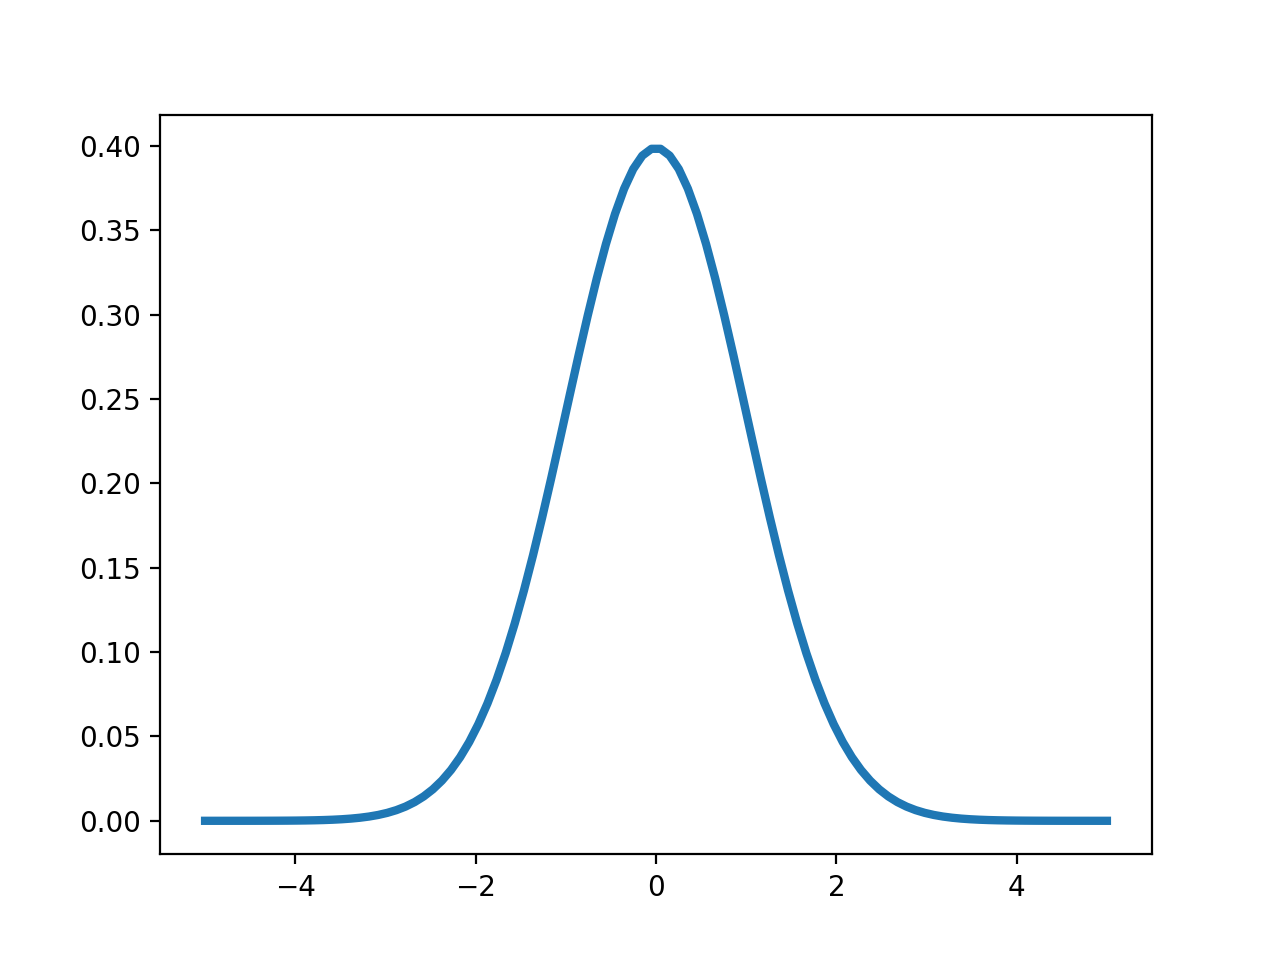

In [17]:
d = dists.norm(loc=0.0, scale=1.0)
x = np.linspace(-5, 5, 100)
plt.plot(x, d.pdf(x), lw=3)


### What's the probability of observing a value greater than 0?

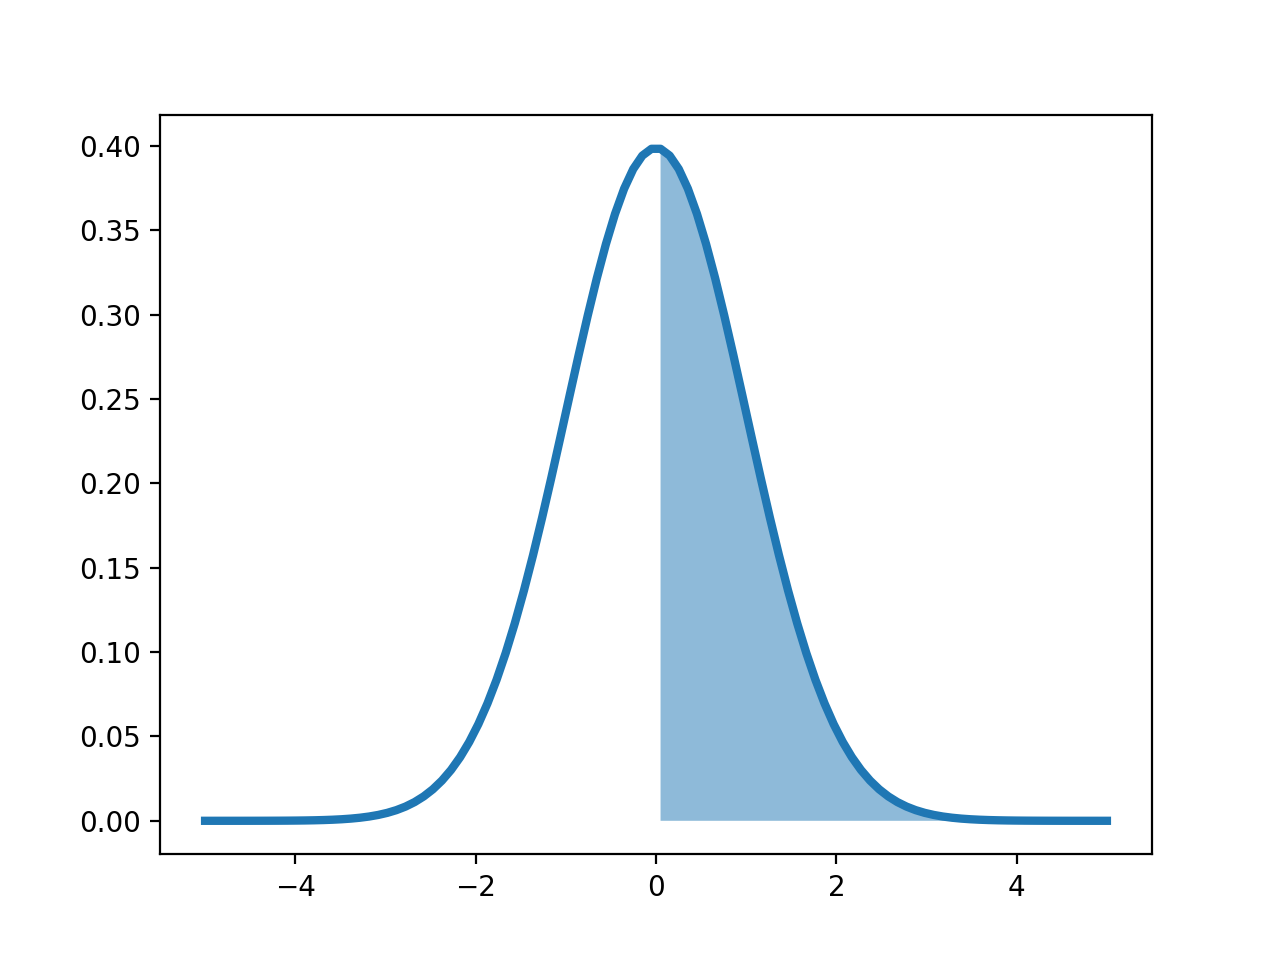

In [18]:
d = dists.norm(loc=0.0, scale=1.0)
x = np.linspace(-5, 5, 100)
plt.plot(x, d.pdf(x), lw=3)
plt.fill_between(x, d.pdf(x), where=x>0.0, alpha=.5)

# Strength theory of memory

- Assumes that we have a baseline familiarity with each item
  - CAT would be strong and have a higher value
  - ALABASTER would be weak and have a lower value
  - VACUUM would have a value somewhere in the middle
- Combining all stimuli gives you a normal distribution of baseline familiarity (i.e., memory strength)
  - This has two parameters, the mean and standard deviation of the normal distribution

## The effect of studying and item

- In strength theory, the process of studying an item adds some amount to that baseline familiarity for some item
- Thus, studying a set of items shifts their strength distribution to the right!

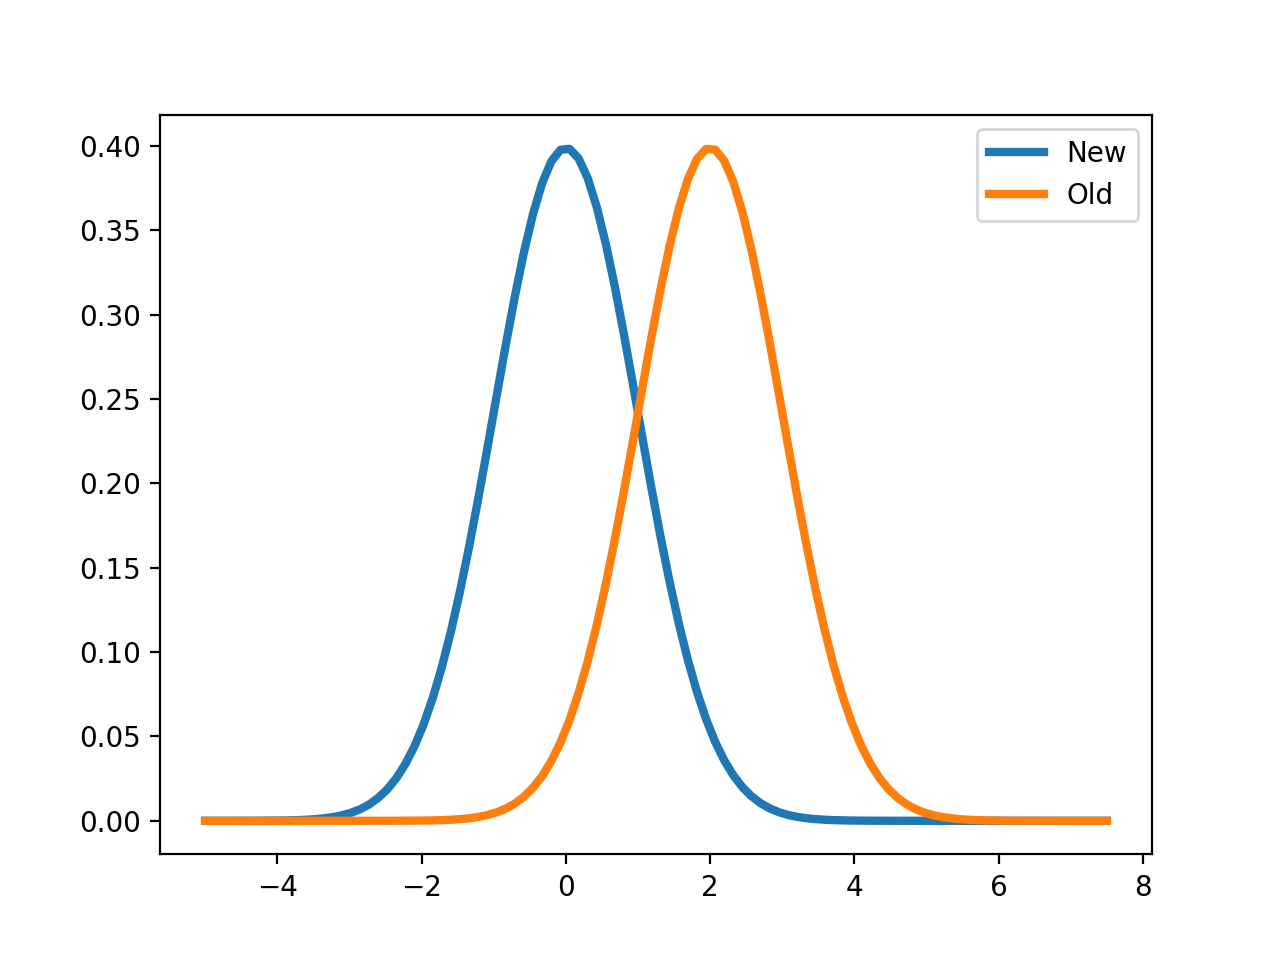

In [24]:
mu = 0.0
sigma = 1.0
alpha = 2.0

# xrange to plot
x = np.linspace(-5, 7.5, 100)

# distribution of new items
y1 = dists.norm(loc=mu, scale=sigma).pdf(x)
plt.plot(x, y1, lw=3)

# distribution of old (studied) items
y2 = dists.norm(loc=mu+alpha, scale=sigma).pdf(x)
plt.plot(x, y2, lw=3)

plt.legend(['New', 'Old'])


# Signal Detection Theory

- Developed by radar operators in the 1940s to help make decisions under uncertainty
- Casts the decision as detecting signal versus noise
- Adds one more parameter, the decision criterion (C)


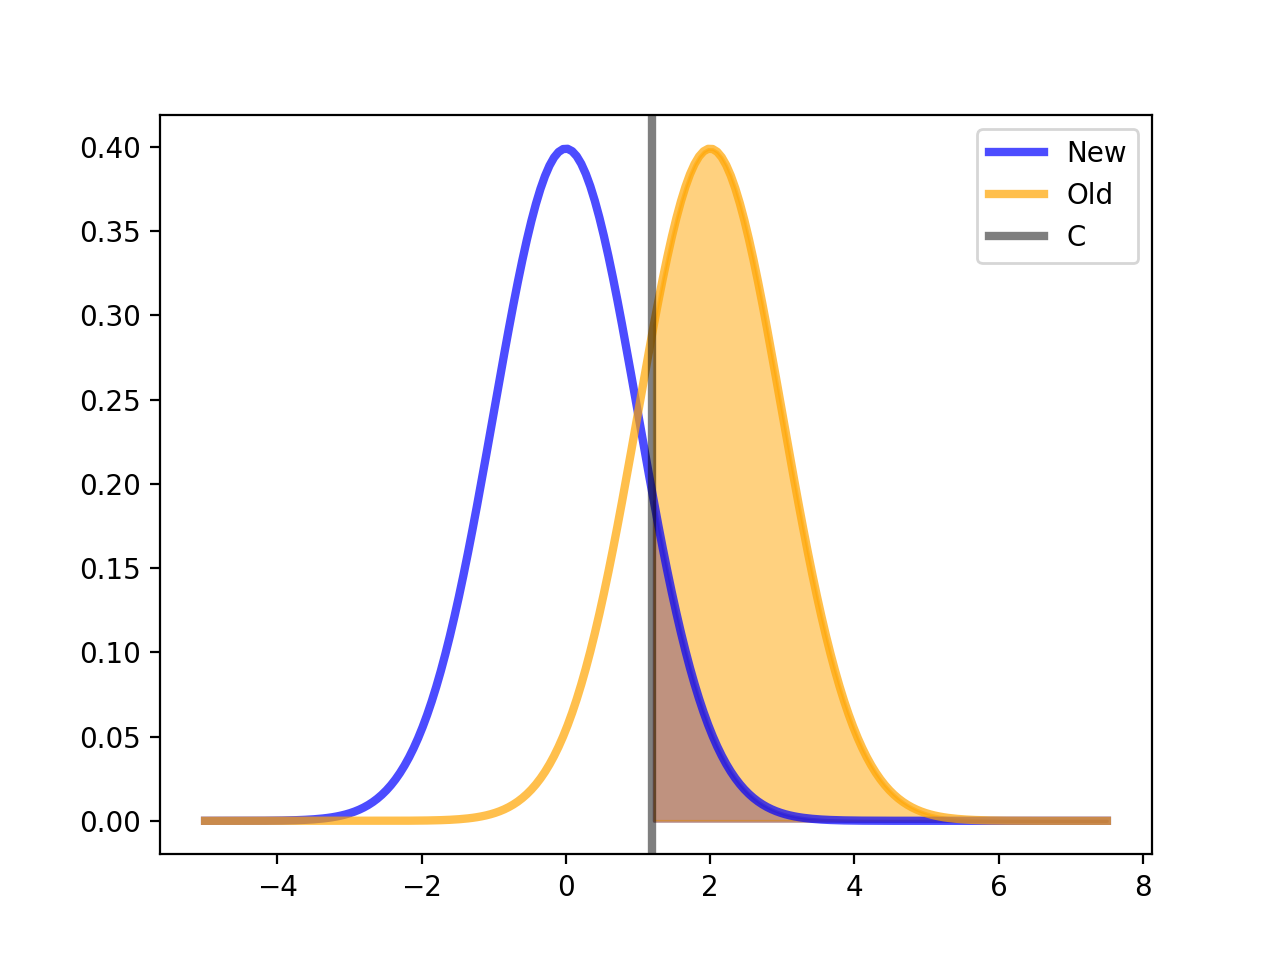

In [72]:
mu = 0.0
sigma = 1.0
alpha = 2.0
c = 1.2

# xrange to plot
x = np.linspace(-5, 7.5, 200)

# distribution of new items
dnew = dists.norm(loc=mu, scale=sigma)
y1 = dnew.pdf(x)
h_new = plt.plot(x, y1, lw=3, color='b', alpha=0.7, label='New')
plt.fill_between(x, dnew.pdf(x), where=x>=c, alpha=.5, color='b')

# distribution of old (studied) items
dold = dists.norm(loc=mu+alpha, scale=sigma)
y2 = dold.pdf(x)
h_old = plt.plot(x, y2, lw=3, color='orange', alpha=0.7, label='Old')
plt.fill_between(x, dold.pdf(x), where=x>=c, alpha=.5, color='orange')

h_c = plt.axvline(c, lw=3, color='k', alpha=0.5, label='C');

plt.legend()

## Bias: How do we pick our decision criterion?

- You don't have control over the signal and noise distributions, but you do have control over the criterion
- Questions:
  - Where should you put your criterion to make the fewest errors?
  - Where should you put your criterion if I said you would get $10 for every hit, and take away nothing for false alarms?
  - How about if you had to pay me every time you made a false alarm?

## Calculating sensitivity

- Under assumptions of equal variance for both the signal and noise distributions, the d' (d-prime) is the measure of sensitivity

$$d' = \frac{((\mu + \alpha) - \mu)}{\sigma}$$


$$d' = \frac{\alpha}{\sigma}$$

- Thus, $d'$ is the difference between the two distributions in units of the standard deviation
- Note, this is independent of the criterion


In [21]:
def calc_dprime(n_hits, n_targets, n_false_alarms, n_lures):
    # calculate corrected hit rate and false alarm rate 
    # (to avoid zeros)
    hr_trans = (n_hits+.5)/(n_targets+1)
    far_trans = (n_false_alarms+.5)/(n_lures+1)
    
    # calculate dprime
    Z = dists.norm.ppf
    dprime = Z(hr_trans) - Z(far_trans)
    return dprime

def calc_c(n_hits, n_targets, n_false_alarms, n_lures):
    # calculate corrected hit rate and false alarm rate 
    # (to avoid zeros)
    hr_trans = (n_hits+.5)/(n_targets+1)
    far_trans = (n_false_alarms+.5)/(n_lures+1)
    
    # calculate bias
    Z = dists.norm.ppf
    c = -(Z(hr_trans) + Z(far_trans)) / 2
    return c


In [22]:
# use the agg method to get the counts we need
iperf = df_t.groupby(['subj', 'cond', 'valence', 'type'])['old_resp'].agg(['sum', 'count', 'mean'])
iperf = iperf.unstack().reset_index()

# collapse the multi-index
iperf.columns = ['_'.join(col).strip() if len(col[1]) > 0 else col[0] 
                 for col in iperf.columns.values]
iperf.head()

,subj,cond,valence,sum_lure,sum_target,count_lure,count_target,mean_lure,mean_target
0,s000,once,neg,1,9,12,12,0.083333,0.750000
1,s000,once,neu,1,7,12,12,0.083333,0.583333
2,s000,once,pos,0,5,12,12,0.000000,0.416667
3,s000,refresh,neg,0,7,12,12,0.000000,0.583333
4,s000,refresh,neu,1,5,12,12,0.083333,0.416667


## Use `apply` to run the functions on each row

In [23]:
# add the dprime as a new column (axis=1 tells it to go by row)
iperf['dprime'] = iperf.apply(lambda x: calc_dprime(x['sum_target'], x['count_target'],
                                                    x['sum_lure'], x['count_lure']),
                                  axis=1)
# add bias (c) as a new column
iperf['c'] = iperf.apply(lambda x: calc_c(x['sum_target'], x['count_target'],
                                                    x['sum_lure'], x['count_lure']),
                                  axis=1)


In [24]:
iperf.loc[iperf.subj=='s003']

,subj,cond,valence,sum_lure,sum_target,count_lure,count_target,mean_lure,mean_target,dprime,c
27,s003,once,neg,3,6,12,12,0.250000,0.500000,0.615141,0.307571
28,s003,once,neu,1,4,12,12,0.083333,0.333333,0.802654,0.797052
29,s003,once,pos,3,3,12,12,0.250000,0.250000,0.000000,0.615141
30,s003,refresh,neg,1,5,12,12,0.083333,0.416667,1.004352,0.696204
31,s003,refresh,neu,0,4,12,12,0.000000,0.333333,1.373100,1.082275
32,s003,refresh,pos,1,6,12,12,0.083333,0.500000,1.198380,0.599190
33,s003,repeat,neg,2,6,12,12,0.166667,0.500000,0.869424,0.434712
34,s003,repeat,neu,0,3,12,12,0.000000,0.250000,1.153684,1.191983
35,s003,repeat,pos,1,5,12,12,0.083333,0.416667,1.004352,0.696204


## Plotting d prime

Now that we have our sensitivity, let's see if there is any consistent result between conditions

<Axes: title={'center': 'dprime'}, xlabel='[valence]'>

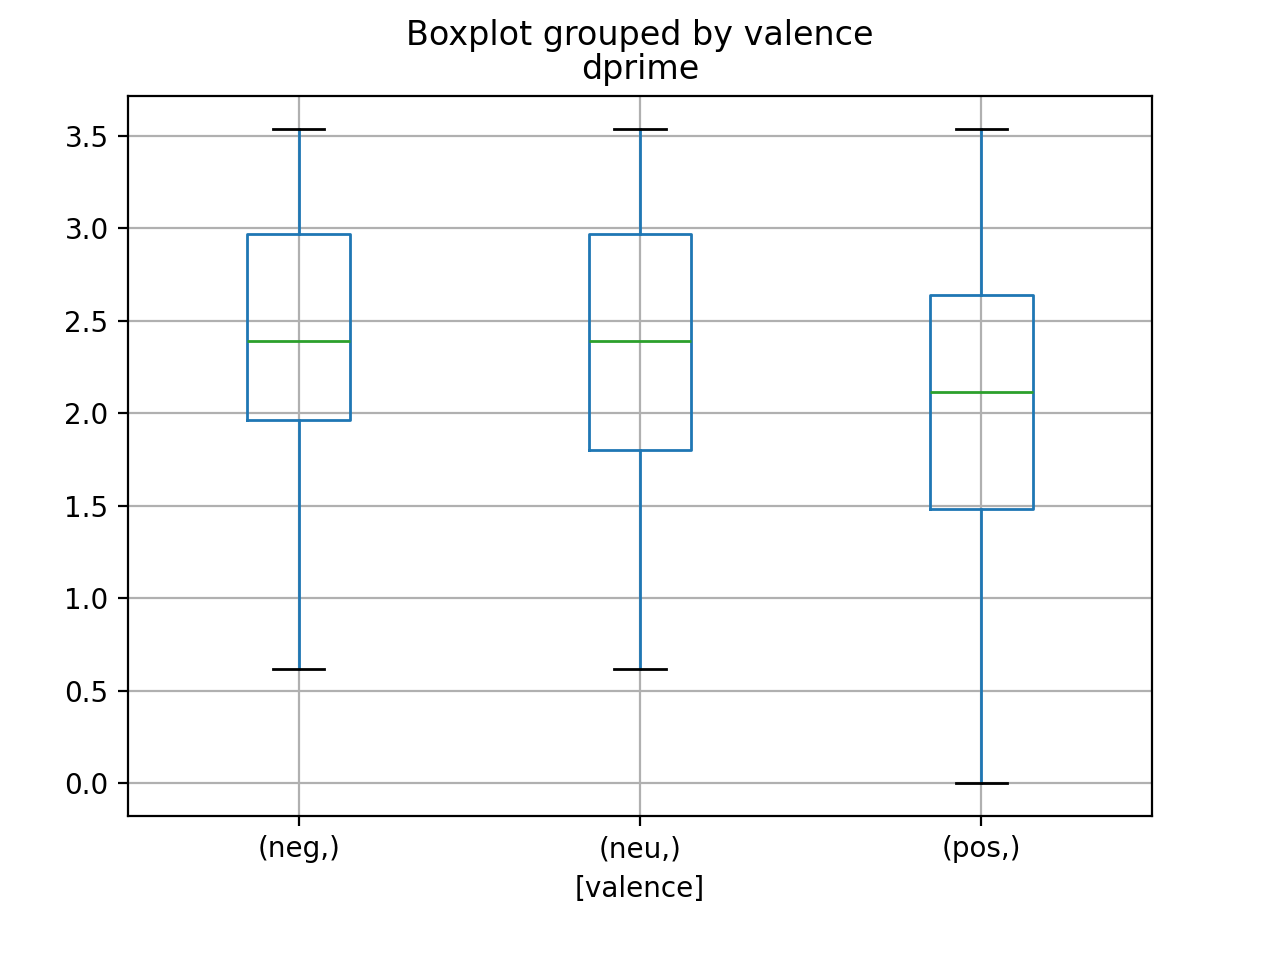

In [35]:
iperf.boxplot(column=['dprime'], by=['valence'])

In [36]:
res = ci_within(iperf, indexvar='subj', 
                withinvars=['cond', 'valence'], 
                measvar='dprime').reset_index()
res

,cond,valence,mean,std,sem,ci,len
0,once,neg,2.257120,0.520320,0.106210,0.219712,24
1,once,neu,2.313835,0.486980,0.099404,0.205634,24
2,once,pos,2.078900,0.588584,0.120144,0.248537,24
3,refresh,neg,2.399801,0.448206,0.091490,0.189261,24
4,refresh,neu,2.286764,0.486941,0.099396,0.205617,24
5,refresh,pos,1.930871,0.573155,0.116995,0.242022,24
6,repeat,neg,2.590505,0.411801,0.084058,0.173888,24
7,repeat,neu,2.550758,0.497600,0.101572,0.210118,24
8,repeat,pos,2.364700,0.465189,0.094956,0.196432,24


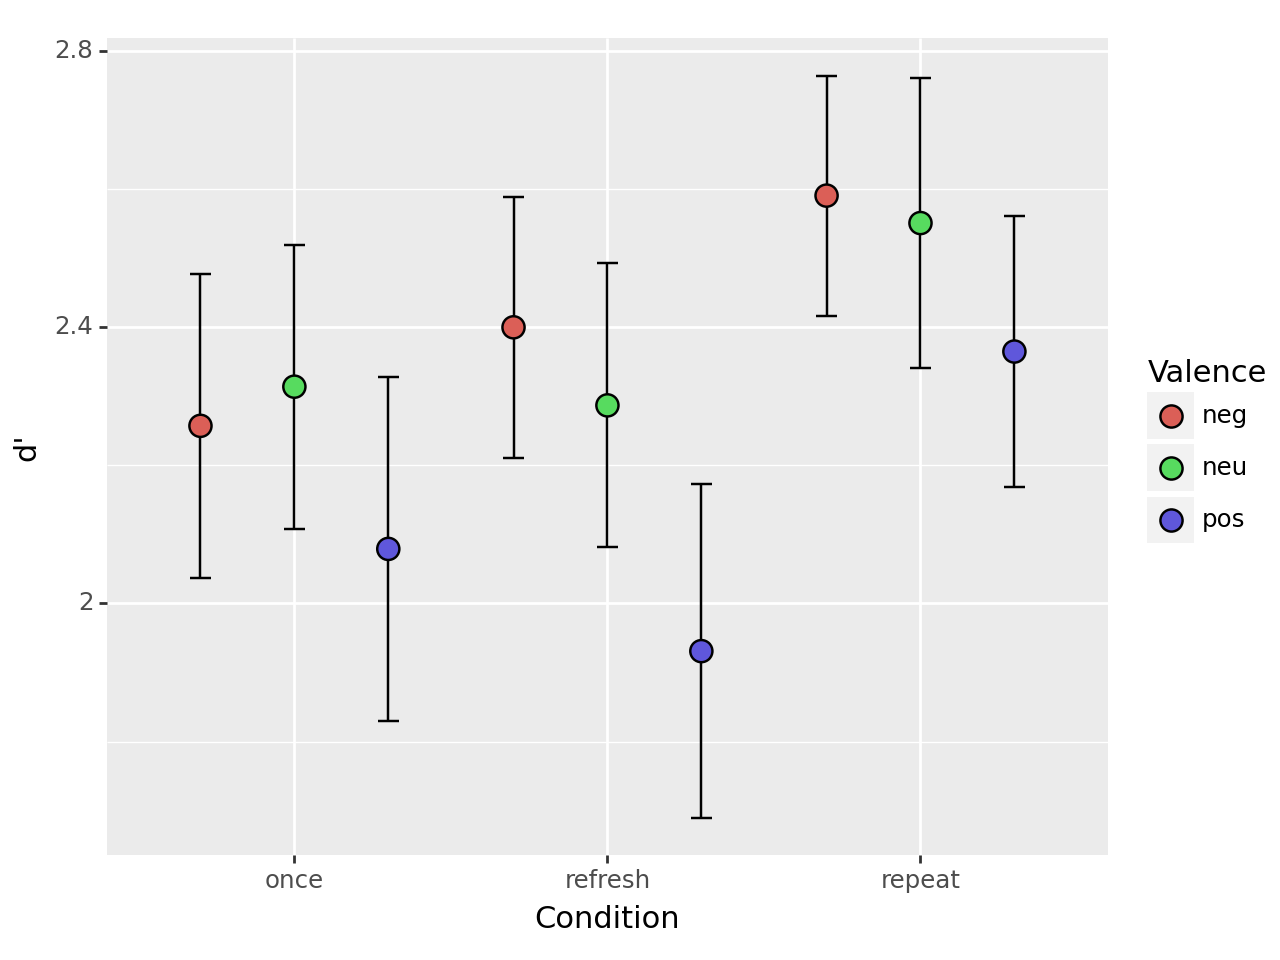

<Figure Size: (640 x 480)>

In [37]:
p = (pn.ggplot(res, pn.aes('cond', 'mean', fill='valence'))
     + pn.geom_errorbar(pn.aes(ymin='mean-ci', ymax='mean+ci', width=0.2), 
                        position=pn.position_dodge(.9))
     + pn.geom_point(position=pn.position_dodge(.9), size=4)
     + pn.labs(x="Condition", y = "d'", fill='Valence')
    )
p

## Let's run a linear models to answer questions!

In [46]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

## Differences in d'

Is there an interaction between condition and valence predicting d'?

In [33]:
# build a least squares regression

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 dprime   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.774
Date:                Thu, 19 Oct 2023   Prob (F-statistic):             0.0837
Time:                        09:25:32   Log-Likelihood:                -244.68
No. Observations:                 216   AIC:                             507.4
Df Residuals:                     207   BIC:                             537.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          2.2571      0.157     14.411      0.000       1.948       2.566
cond[T.refresh]                    0.1427      0.221      0.644      0.520      -0.294       0.579
cond[T.repeat]                     0.3334      0.221      1.505      0.134      -0.103       0.770
valence[T.neu]                     0.0567      0.221      0.256      0.798      -0.380       0.493
valence[T.pos]                    -0.1782      0.221     -0.805      0.422      -0.615       0.258
cond[T.refresh]:valence[T.neu]    -0.1698      0.313     -0.542      0.588      -0.787       0.448
cond[T.repeat]:valence[T.neu]     -0.0965      0.313     -0.308      0.758      -0.714       0.521
cond[T.refresh]:valence[T.pos]    -0.2907      0.313     -0.928      0.354      -0.908       0.327
cond[T.repeat]:valence[T.pos]     -0.0476      0.313     -0.152      0.879      -0.665       0.570
==============================================================================
Omnibus:                        3.543   Durbin-Watson:                   0.938
Prob(Omnibus):                  0.170   Jarque-Bera (JB):                2.582
Skew:                          -0.108   Prob(JB):                        0.275
Kurtosis:                       2.510   Cond. No.                         13.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# run a type 2 anova on the model to aid with interpretation


,sum_sq,df,F,PR(>F)
cond,4.062544,2.0,3.450187,0.033577
valence,3.666216,2.0,3.113598,0.046529
cond:valence,0.627312,4.0,0.266378,0.899332
Residual,121.869710,207.0,NaN,NaN


## What about bias?

It could be that there is a systematic bias in the responses due to the condition and valence.

In [44]:
# use ci_within to calculate proper within-subjects corrected errors
# for c, grouped by cond and valence

# YOUR CODE HERE
res = ...

res

,cond,valence,mean,std,sem,ci,len
0,once,neg,0.230423,0.302345,0.061716,0.127669,24
1,once,neu,0.240074,0.302711,0.061791,0.127824,24
2,once,pos,0.302715,0.237022,0.048382,0.100086,24
3,refresh,neg,0.142798,0.203124,0.041463,0.085772,24
4,refresh,neu,0.250498,0.270998,0.055317,0.114432,24
5,refresh,pos,0.240341,0.230221,0.046994,0.097214,24
6,repeat,neg,0.071747,0.243172,0.049637,0.102683,24
7,repeat,neu,0.214108,0.282652,0.057696,0.119353,24
8,repeat,pos,0.212063,0.190048,0.038793,0.080250,24


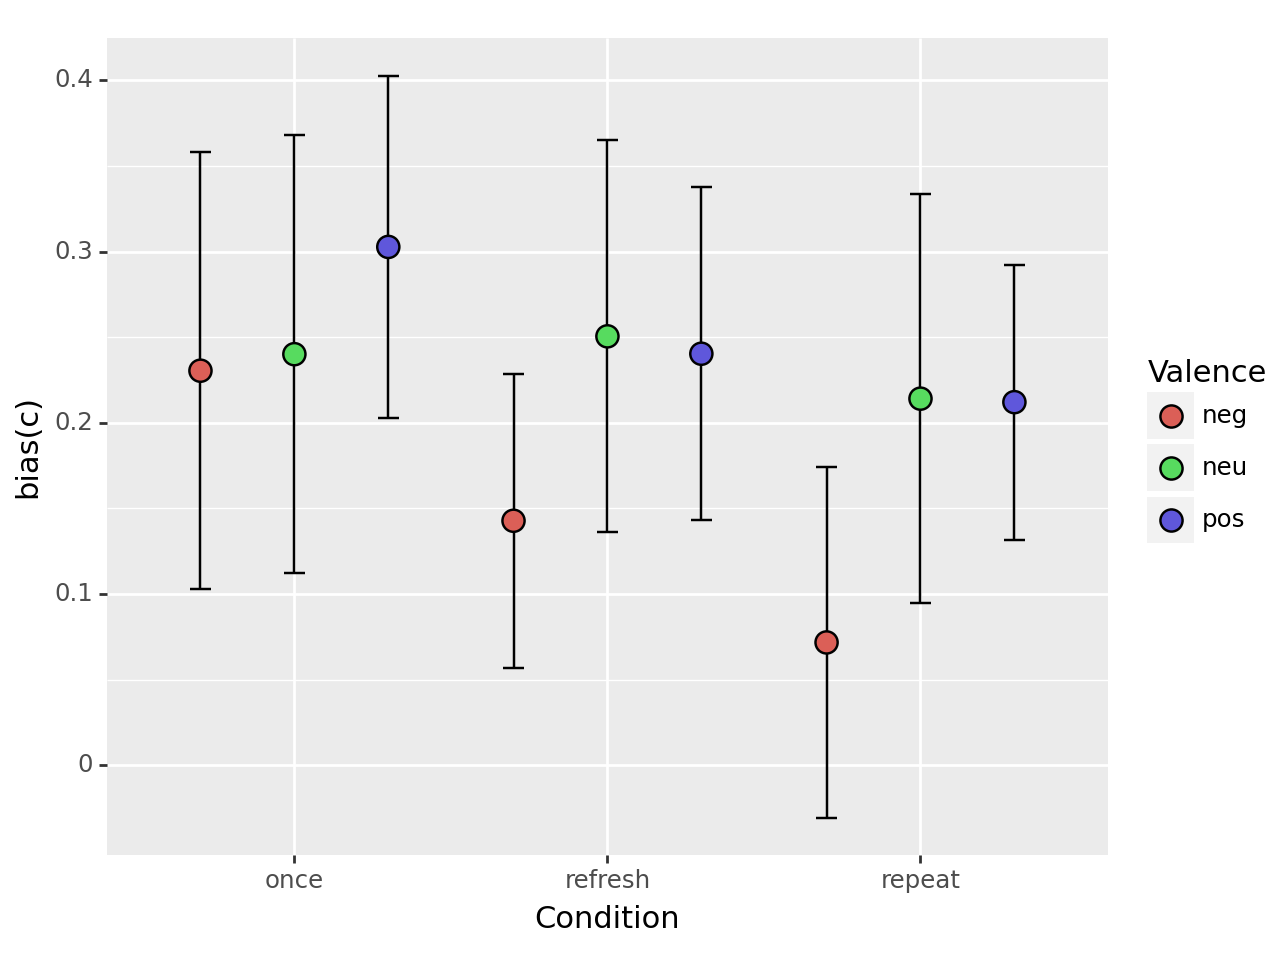

<Figure Size: (640 x 480)>

In [53]:
# use plotnine to plot these results
# make sure to set correct labels

# YOUR CODE HERE

In [47]:
# build a linear regression of the full model

# YOUR CODE HERE
m0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      c   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.8962
Date:                Thu, 19 Oct 2023   Prob (F-statistic):              0.521
Time:                        13:28:00   Log-Likelihood:                -73.673
No. Observations:                 216   AIC:                             165.3
Df Residuals:                     207   BIC:                             195.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.2304      0.071      3.247      0.001       0.091       0.370
cond[T.refresh]                   -0.0876      0.100     -0.873      0.384      -0.285       0.110
cond[T.repeat]                    -0.1587      0.100     -1.581      0.115      -0.357       0.039
valence[T.neu]                     0.0097      0.100      0.096      0.923      -0.188       0.208
valence[T.pos]                     0.0723      0.100      0.720      0.472      -0.126       0.270
cond[T.refresh]:valence[T.neu]     0.0980      0.142      0.691      0.490      -0.182       0.378
cond[T.repeat]:valence[T.neu]      0.1327      0.142      0.935      0.351      -0.147       0.413
cond[T.refresh]:valence[T.pos]     0.0253      0.142      0.178      0.859      -0.255       0.305
cond[T.repeat]:valence[T.pos]      0.0680      0.142      0.479      0.632      -0.212       0.348
==============================================================================
Omnibus:                        0.573   Durbin-Watson:                   1.063
Prob(Omnibus):                  0.751   Jarque-Bera (JB):                0.707
Skew:                           0.093   Prob(JB):                        0.702
Kurtosis:                       2.790   Cond. No.                         13.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
# run a type 2 anova
# YOUR CODE HERE


,sum_sq,df,F,PR(>F)
cond,0.303166,2.0,1.254245,0.287450
valence,0.443166,2.0,1.833450,0.162448
cond:valence,0.120189,4.0,0.248621,0.910269
Residual,25.017177,207.0,NaN,NaN


## What about RTs

Did you make faster or slower responses, depending on the condition and valence? 

In [ ]:
# run ci_within 

In [ ]:
# make plot

In [49]:
# run linear regression

In [ ]:
# run anova

## Conclusion

- Write a short summary (a couple bullet list items) for the results we found (and/or didn't find)


## Assignment before next class

- The small set of analyses to run on the refresh memory data outlined above will be your assignment for this week
  - This will be due on ***Thursday*** next week
- We'll also post the Spacing experiment
  - Please upload the zip file of your data by Tuesday night

### See you next week!!!